# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**
* Данные геологоразведки трёх регионов находятся в файлах: 
    * /datasets/geo_data_0.csv. 
    * /datasets/geo_data_1.csv. 
    * /datasets/geo_data_2.csv. 
* Признаки:
    * `id` — уникальный идентификатор скважины;
    * `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* Целевой признак:
    * `product` — объём запасов в скважине (тыс. баррелей).
    
**Условия задачи:**
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Этапы работы:**
* Загрузка и подготовка данных. 
* Обучение и проверка модели для каждого региона.
* Подготовка к расчёту прибыли.
* Расчет прибыли и рисков для каждого региона.

## Загрузка и подготовка данных

Импортируем библиотеки и модули, которые потребуются для выполнения проекта

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from numpy.random import RandomState


import warnings
warnings.filterwarnings('ignore')

Данные геологоразведки трёх регионов находятся в файлах. Сохраним данные в трех переменных.

In [2]:
try:
    data_0 = pd.read_csv('datasets/geo_data_0.csv')
    data_1 = pd.read_csv('datasets/geo_data_1.csv')
    data_2 = pd.read_csv('datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

### Обзор данных

Для каждого датасета выведем на экран выведем на экран пять первых строк датасета, информацию о датасете методом `info()`, описательную статистику методом `describe()`, гистограммы частот для числовых данных, матрицу корреляции  и количество полных дубликатов. В дальнейшем для однотипных действий с датасетами также по возможности будем писать функции.

In [3]:
def data_overview(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    
    data.hist(figsize=(12,7), bins=100)
    plt.show()
    
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
    plt.show()
    
    print('Количество полных дубликатов:', data.duplicated().sum()) 
    return

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


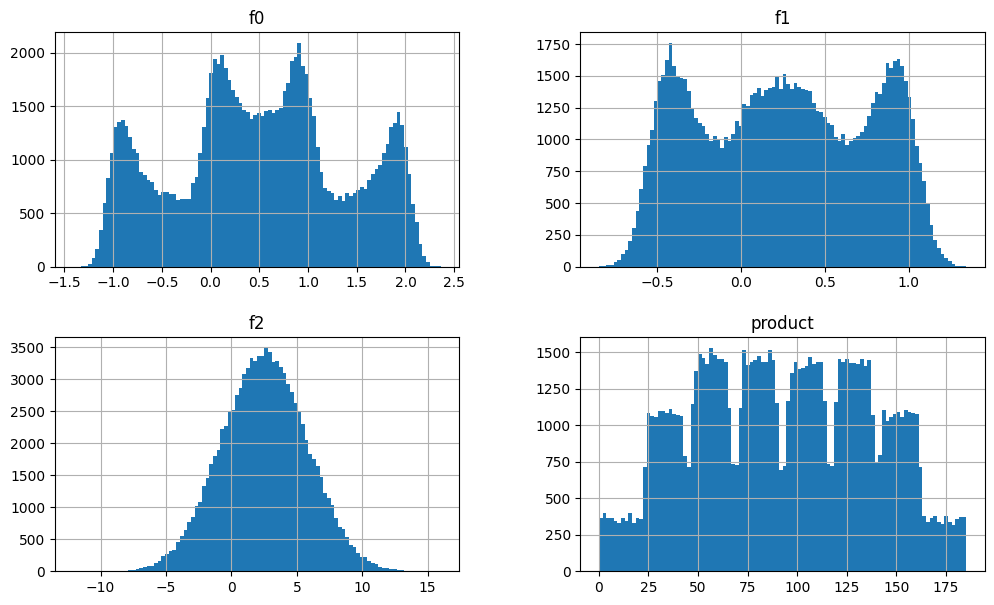

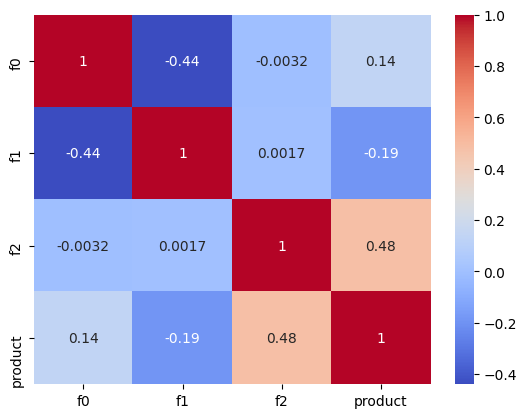

Количество полных дубликатов: 0


In [4]:
data_overview(data_0)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


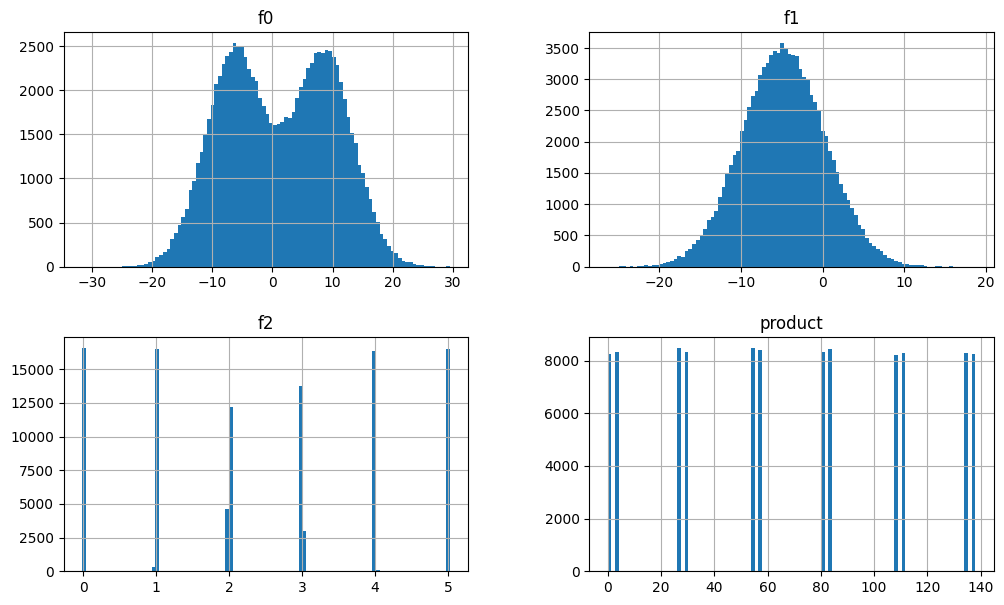

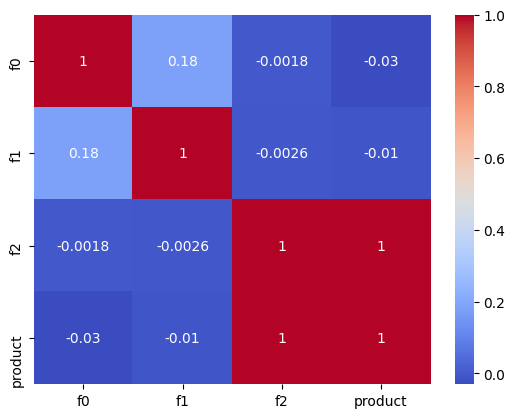

Количество полных дубликатов: 0


In [5]:
data_overview(data_1)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


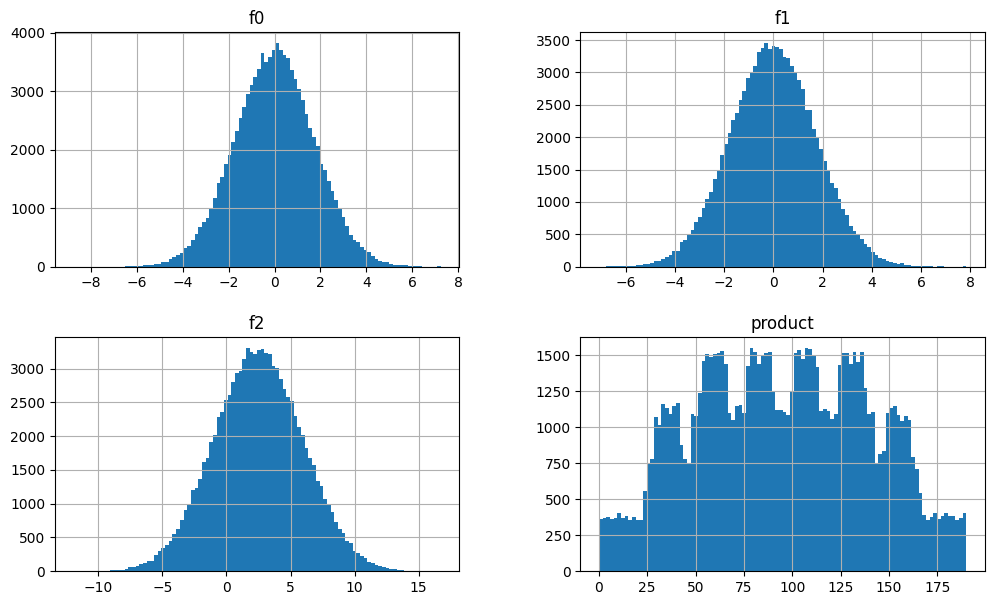

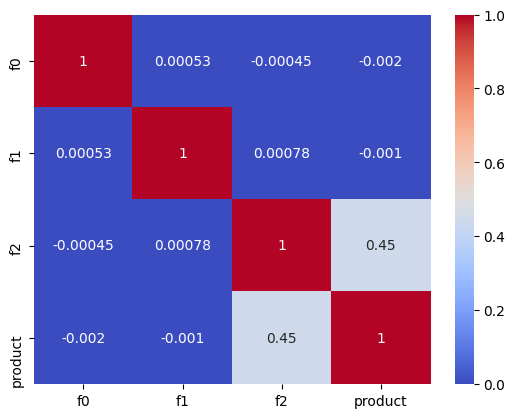

Количество полных дубликатов: 0


In [6]:
data_overview(data_2)

**Обзор данных:**
* Все три датасета одинаковы по размеру – содержат по 100000 записей.
* Три столбца (`f0`, `f1` и `f2`) имеют числовой формат, один (`id`) – тип object. Пропуски в данных отсутствуют.
* Во всех трех регионах наблюдается наибольшая между целевым признаком и признаком `f2`.
* Среднее и медиана объемов запасов нефти выше всего в регионе 2 (`data_2`, оба значения около 95), несколько ниже в регионе 1 (`data_0`, 91-92), значения признака `product` распределены похожим образом (см. гистограммы частот). Ниже всего показатели среднего и медианы для региона 1 (`data_1`), разница между средним и медианой больше, чем для других регионов (среднее – 69, медиана – 57).
* Из трех признаков (`f0`, `f1` и `f2`) наиболее наиболее высокую положительную корреляцию с `product` показывает `f2`.

**Подготовка данных** к обучению. Для каждого датасета:
* удалим столбец `id`, содержащий идентификационные дынные, не являющиеся значением признака.
* разделим данные для на обучающую и валидационную выборки в соотношении 75:25.
* по условиям все признаки (`f0`, `f1` и `f2`) одинаково значимы, масштабируем признаки.

### Удалим столбец `id`

Функция для удаления cтолбца.

In [7]:
def drop_column(data, column):
    return data.drop(column, axis = 1)

Удалим столбец `id`.

In [8]:
data_0 = drop_column(data_0, 'id')
data_1 = drop_column(data_1, 'id')
data_2 = drop_column(data_2, 'id')

In [9]:
data_0.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


Cтолбец `id` удален.

### Разделим данные на обучающую и валидационную выборки (75:25)

1. Целевой признак – значение в столбце `product`. Cоздадим переменные для признаков (`features`) и целевого признака (`target`). Напишем для этого функцию.

In [10]:
def features_target_split(data, target):
    features = drop_column(data, target) # применяем ранее написанную функцию drop_column
    target = data[target]
    return features, target

In [11]:
features_0, target_0 = features_target_split(data_0, 'product')
features_1, target_1 = features_target_split(data_1, 'product')
features_2, target_2 = features_target_split(data_2, 'product')

In [12]:
# выведем на экран размеры таблиц
print(features_0.shape)
print(target_0.shape)

(100000, 3)
(100000,)


2. Разобьем данные обучающую и валидационную выборки в соотношении 75:25. Напишем для этого функцию.

In [13]:
def train_valid_split(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    return features_train, features_valid, target_train, target_valid

In [14]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_valid_split(features_0, target_0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_valid_split(features_1, target_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_valid_split(features_2, target_2)

In [15]:
# выведем на экран размеры таблиц, которые хранятся в переменных
print(features_train_0.shape)
print(target_train_0.shape)
print(features_valid_0.shape)
print(target_valid_0.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


3. Масштабируем количественные методом стандартизации данных

In [16]:
def standard_scaler(features_train, features_valid):
    numeric = features_train.columns
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    return features_train, features_valid

In [17]:
features_train_0, features_valid_0 = standard_scaler(features_train_0, features_valid_0)
features_train_1, features_valid_1 = standard_scaler(features_train_1, features_valid_1)
features_train_2, features_valid_2 = standard_scaler(features_train_2, features_valid_2)

In [18]:
display(features_train_0.head())
features_valid_0.head()

,f0,f1,f2
27212,-0.544828,1.390264,-0.094959
7866,1.455912,-0.480422,1.209567
62041,0.260460,0.825069,-0.204865
70185,-1.837105,0.010321,-0.147634
82230,-1.299243,0.987558,1.273181


,f0,f1,f2
71751,0.517917,-0.610097,-0.126226
80493,0.568391,-0.086063,-0.814914
2655,0.805688,-1.613289,-1.341342
53233,0.222503,-1.355437,-0.597275
91141,-0.087941,1.433113,-0.544588


### Выводы по разделу 1

1. Данные загружены и изучены.
2. Пропуски и дубликаты отсутствуют.
3. Удален столбец `id`, данные в котором не являются признаком.
4. Данные разделены на обучающую и валидационную выборки в соотношении 75:25.
5. Данные разделены на выборки, количественные признаки `f0`, `f1`, `f2` масштабированы.

Данные подготовлены, можно приступать к обучению.

## Обучение и проверка модели

Для обучения модели подходит только линейная регрессия. Напишем функцию, которая вернет предсказания на валидационной выборке и выведет на экран средний запас предсказанного сырья и RMSE модели.

In [19]:
def lin_regress(features_train, target_train, features_valid, target_valid): 
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = pd.Series(model.predict(features_valid), index=target_valid.index)
    print('Средний объем предсказанного сырья, тыс. баррелей:', predicted_valid.mean())
    print('RMSE модели:', mean_squared_error(target_valid, predicted_valid) ** 0.5)
    return predicted_valid

### Регион 0

In [20]:
predicted_valid_0 = lin_regress(features_train_0, target_train_0, features_valid_0, target_valid_0)

Средний объем предсказанного сырья, тыс. баррелей: 92.59256778438035
RMSE модели: 37.5794217150813


### Регион 1

In [21]:
predicted_valid_1 = lin_regress(features_train_1, target_train_1, features_valid_1, target_valid_1)

Средний объем предсказанного сырья, тыс. баррелей: 68.728546895446
RMSE модели: 0.893099286775617


### Регион 2

In [22]:
predicted_valid_2 = lin_regress(features_train_2, target_train_2, features_valid_2, target_valid_2)

Средний объем предсказанного сырья, тыс. баррелей: 94.96504596800489
RMSE модели: 40.02970873393434


### Сохраним правильные ответы и предсказания в одну таблицу

In [23]:
def target_predictions_table(target_valid, predicted_valid):
    target_predictions_table= pd.DataFrame({'target': target_valid.tolist(), 
                                            'predictions': predicted_valid})
    return target_predictions_table

In [24]:
target_predictions_table_0 = target_predictions_table(target_valid_0, predicted_valid_0)
target_predictions_table_1 = target_predictions_table(target_valid_1, predicted_valid_1)
target_predictions_table_2 = target_predictions_table(target_valid_2, predicted_valid_2)

In [25]:
target_predictions_table_0.head()

,target,predictions
71751,10.038645,95.894952
80493,114.551489,77.572583
2655,132.603635,77.892640
53233,169.072125,90.175134
91141,122.325180,70.510088


### Выводы по разделу 2

1. Данные разбиты на выборки на предыдущем этапе работы.
2. Модели обучены. Предсказания на валидационной  выборке сохранены в переменных `predicted_valid_0`, `predicted_valid_1`и `predicted_valid_2`. Правильные ответы на валидационной выборке соответственно хнанятся в переменных `target_valid_0`, `target_valid_1`и `target_valid_2`. Данные сохранены в таблицах `target_predictions_table_0`, `target_predictions_table_1`, `target_predictions_table_2`
3. Средние предсказанные значения близки к средним реальным значениям (см. обзор данных в разделе 1). Регион 1 показывает самое низкое значение (68,73 тыс. баррелей), в то время как для региона 0 и региона 2 эти дначения выше (92.59 и 94.97 тыс. баррелей соответственно).
4. Предсказания модели линейной регрессии для регион 1 наиболее точные: определяется лучшее (наименьшее) значение RMSE (0.89). Для регионов 0 и 2 значения RMSE значительно выше (около 37.58 и 40.03 соответственно).

## Подготовка к расчёту прибыли

1. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и сравним полученный объём сырья со средним запасом в каждом регионе. 

По условиям задачи ири разведке региона исследуют 500 точек, из которых выбирают 200 лучших для разработки. Бюджет на разработку скважин в регионе — 10 млрд рублей. Доход с каждой единицы продукта составляет 450 тыс. рублей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Ключевые значения для расчётов сохраним в отдельных переменных.
* `budget` -  бюджет на разработку скважин в регионе (по условиям задачи равен 10 млрд. рублей)
* `income_per_unit` – доход с каждой единицы продукта (по условиям задачи 450 тыс. рублей)
* `sample_wells` – количество точек, исследуемых при разведке региона (по условиям задачи 500)
* `best_wells` – количество точек, выбранных для разработки (по условиям задачи 200)
* `max_probability_of_losses` – максимально допустимая вероятность убытков по региону (по условиям задачи 2,5%)

In [27]:
BUDGET = 10_000_000_000
INCOME_PER_UNIT = 450_000
SAMPLE_WELLS = 500
BEST_WELLLS = 200

Достаточный объем сырья для для безубыточной разработки новой скважины рассчитаем по формуле (при делении бюджета на количество разрабатываемых скважин получаем стоимость разработки одной скважины и, соответственно, сумма которую нужно "вернуть" для безубыточной разработки; полученную величину разделим на доход с тыс. баррелей, т.е. узнаем, сколько тыс. баррелей нужно, чтобы возместить расходы на разработку):

    бюджет региона / количество разрабатываемых скважин / доход с единицы продукта

In [28]:
print('Достаточный объём сырья для безубыточной разработки новой скважины:', BUDGET/BEST_WELLLS/INCOME_PER_UNIT)

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11111111111111


### Вывод по разделу 3

Достаточный объем сырья для безубыточной разработки новой скважины составляет 111.11 тыс. баррелей. Напомним, что средний запас (реальный и предсказанный) по регионам составляет около 92 тыс. баррелей для региона 0, 68 тыс. баррелей для региона 1 и 95 тыс. баррелей для региона 2. Таким образом, средние показатели по всем трем регионам оказываются ниже, чем достаточный объем сырья, необходимый для безубыточной разработки, т.е. при случайном выборы скважин для разработки есть вероятность убытков.

## Расчёт прибыли и рисков 

### Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели

In [29]:
def revenue(target, predictions, count):
    predictions_sorted = predictions.sort_values(ascending=False)
    target_selected = target[predictions_sorted.index][:count]
    return target_selected.sum() * INCOME_PER_UNIT - BUDGET

### Посчитаем риски и прибыль для каждого региона

In [30]:
def bootstrap_revenue_loss(predictions, target):
    state = np.random.RandomState(12345)
    
    values = []
    for i in range(1000):
        target_sample = target.sample(n=SAMPLE_WELLS, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        values.append(revenue(target_sample, predictions_sample, BEST_WELLLS))

    values = pd.Series(values)
    loss_probability = (values<0).mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
        
    mean = values.mean()
    print("Средняя выручка региона:", mean)
    print("95% доверительный интервал", lower, upper)
    print("Вероятность убытков", loss_probability)
    return

#### Регион 0

In [31]:
bootstrap_revenue_loss(target_predictions_table_0['predictions'], target_predictions_table_0['target'])

Средняя выручка региона: 425938526.91059244
95% доверительный интервал -102090094.83793654 947976353.3583689
Вероятность убытков 0.06


#### Регион 1

In [32]:
bootstrap_revenue_loss(target_predictions_table_1['predictions'], target_predictions_table_1['target'])

Средняя выручка региона: 515222773.4432899
95% доверительный интервал 68873225.37050176 931547591.2570494
Вероятность убытков 0.01


#### Регион 2

In [33]:
bootstrap_revenue_loss(target_predictions_table_2['predictions'], target_predictions_table_2['target'])

Средняя выручка региона: 435008362.7827556
95% доверительный интервал -128880547.32978901 969706954.1802661
Вероятность убытков 0.064


### Вывод по разделу 4

При применении техники *Bootstrap* наивысшее значение средней прибыли показывает регион 1, также это единственный регион, для которого вероятность убытков менее требуемых 2.5%. Таким образом, несмотря на то, что средние запасы сырья в регионе 1 меньше, чем в других двух регионах, именно его следует предложить для разработкии.

## Итоги

На основании данныхо  пробах нефти в трёх регионах построена модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Возможная прибыль и риски проанализированы техникой *Bootstrap*. В ходе работы были выполнены следующие действия:

* данные загружены и подготовлены;
* для каждого региона обучена и проверена модель;
* осуществлена подготовка к расчёту прибыли;
* рассчитаны прибыль и риски для каждого региона.

**Общий вывод**: 
В результате исследования предложите для разработки скважин регион предложен регион 1, поскольку для него получено наибольшее значение средней прибыли и нпименьшая вероятность убытков. 